# A complete analysis for predicting banking behavior by the classification method.

#                        By Huanwang Shawn Yang


The data was obtained from the UCI data resource http://archive.ics.uci.edu/ml/datasets/Bank+Marketing


# Summary: 

Here, I utilized Machine Learning (classification) algorithms to predict the banking behavior based on 41188 observations and 20 features. This project serves as two purposes:

1. Explore data analysis to achieve the best prediction (best modeling) of for classification. 

2. Test the python module that I have developed to automatically pick the best ML algorithm and the best hyperparameters from a large list of Sklearn library. It also serves as a prototype for feature selections. This model is significantly better than the prediction found from the public domain https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8 


# Understand the data below

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (if variable y=1, yes; if y=0, no). Below is the feature Information:


# bank client data:
1 - age (numeric)   
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)   
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  

# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')  
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. 
  
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)   
14 - previous: number of contacts performed before this campaign and for this client (numeric)  
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')   

# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)   
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)   
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)   
20 - nr.employed: number of employees - quarterly indicator (numeric)  

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')


In [1]:
import sys  #utilized the auto-selection module that I developed
sys.path.append('/Users/hyang/data-science/Pyth/ML-tune/')

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=16)
from sklearn.cross_validation import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline


/Users/hyang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load data and show information

data=pd.read_csv('banking.csv', header=0)

numdf = data.select_dtypes(include=[np.number])
catdf = data.select_dtypes(exclude=[np.number])
print 'numerical features=', numdf.columns.values
print '\ncategorical features=', catdf.columns.values

print data.head()
print 'data shape=', data.shape
print 'missing value=', data.isnull().values.any() 

data.loc[:'education'].replace(['basic.4y','basic.6y','basic.9y'], 
                               ['basic','basic','basic' ], inplace=True)

print 'Education=\n', data['education'].unique()
print data.y.value_counts()
#print data.groupby('y').mean()
#print data.groupby('education').mean()



numerical features= ['age' 'duration' 'campaign' 'pdays' 'previous' 'emp_var_rate'
 'cons_price_idx' 'cons_conf_idx' 'euribor3m' 'nr_employed' 'y']

categorical features= ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'poutcome']
   age          job  marital          education  default housing loan  \
0   44  blue-collar  married           basic.4y  unknown     yes   no   
1   53   technician  married            unknown       no      no   no   
2   28   management   single  university.degree       no     yes   no   
3   39     services  married        high.school       no      no   no   
4   55      retired  married           basic.4y       no     yes   no   

    contact month day_of_week ...  campaign  pdays  previous     poutcome  \
0  cellular   aug         thu ...         1    999         0  nonexistent   
1  cellular   nov         fri ...         1    999         0  nonexistent   
2  cellular   jun         thu ...         3      6        

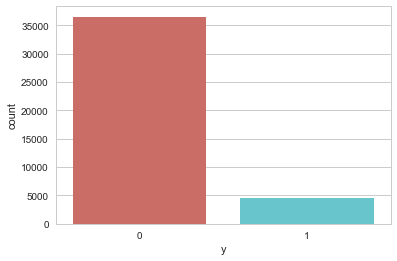

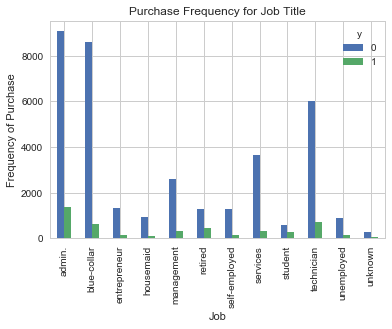

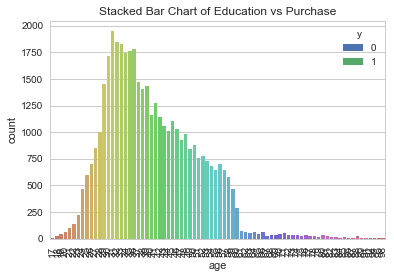

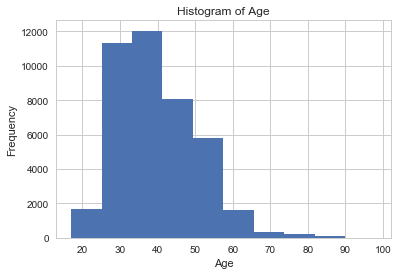

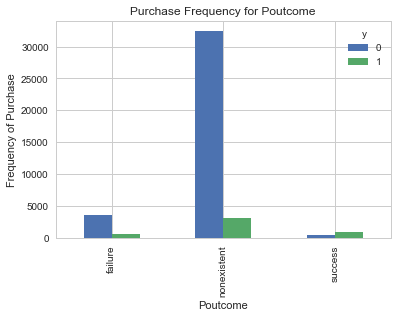

In [3]:
#visulize some data
sns.countplot(data=data, x='y', palette='hls')
#plt.savefig('count_plot')

#print data.groupby('y').mean()
#print data.groupby('education').mean()

#some visualizations
pd.crosstab(data.job, data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
#plt.savefig('purchase_fre_job')

#make new graph
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
#plt.savefig('edu_vs_pur_stack')

#check age
sns.countplot(data=data, x='age', palette='hls')
plt.show()

plt.hist(x=data.age)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
#plt.savefig('hist_age')
plt.show()

pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

#data.info()


In [4]:
#add dummy variables (regression need number), drop the first one (duplicated)
cat_vars=['job','marital','education','default','housing','loan',
          'contact','month','day_of_week','poutcome']

for var in cat_vars:
    cat_list = pd.get_dummies(data[var], prefix=var, drop_first=True)
    data=data.join(cat_list)

#print data.info()
#print data.columns.values
print 'Shape after adding dummies=', data.shape


Shape after adding dummies= (41188, 62)


In [5]:
# get the final data
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars] 

data_final=data[to_keep]

X=data_final.drop('y', axis=1)
y=data_final['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print 'Training set (%d) and test set (%d).' %(len(X_train), len(X_test))
print 'shape of X_train & y_train =', X_train.shape, y_train.shape


Training set (28831) and test set (12357).
shape of X_train & y_train = (28831, 51) (28831,)


In [6]:
import ml_utility as ut
X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'RFE', 20)
#X_train, X_test=ut.feature_selection(X_train, X_test, y_train, y_test, 'model', 20)
print 'After feature selection: shape of X_train & y_train =', X_train.shape, y_train.shape


The shape of Xtrain =  (28831, 51)
The shape of Xtrain_select =  (28831, 20)
The socre of LogisticRegression = 0.9123
After feature selection: shape of X_train & y_train = (28831, 20) (28831,)


In [7]:

import ml_tune_para as tune

#tuning paramters
#tune.auto_tune_classifier(X_train, y_train)
#tune.tune_classifier('RandomForestClassifier', X_train, y_train)
#tune.tune_classifier('LogisticRegression', X_train, y_train)
#tune.tune_classifier('GaussianProcessClassifier', X_train, y_train)
tune.tune_classifier('XGBClassifier', X_train, y_train)
#tune.tune_classifier('GradientBoostingClassifier', X_train, y_train)



Tuning hyperparameters for sklearn.xgboost.XGBClassifier ...
('\nbest_score=', 0.9135305747285908)
('best_params=', {})
('best_estimator=', XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1))


In [8]:
# print all the trained models and hyperparameters in order

fp=open('tuned_para.log', 'r').readlines()
print 'The auto-tuned hyperparameters below:\n'
for x in fp : print x.rstrip()

The auto-tuned hyperparameters below:

score= 0.912698
hyper_para= {'max_features': 'sqrt', 'n_estimators': 100, 'criterion': 'gini', 'max_depth': None}
model= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

score= 0.911588
hyper_para= {'max_features': None, 'splitter': 'best', 'max_depth': 4}
model= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
     

Accuracy of RandomForest classifier on test set: 0.92
Classification accuracy= 0.917779396294
Classification AUC_ROC=  0.73856134036
Confusion_matrix=
[[10642   339]
 [  677   699]]

Classification_report=
             precision    recall  f1-score   support

          0       0.94      0.97      0.95     10981
          1       0.67      0.51      0.58      1376

avg / total       0.91      0.92      0.91     12357



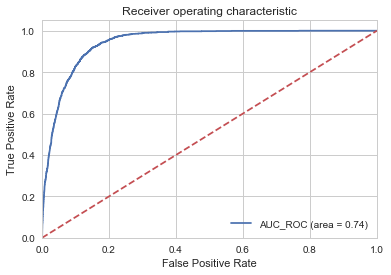

In [9]:
#fitting the model selected from the best training
from  sklearn.ensemble import RandomForestClassifier
from  sklearn.linear_model import LogisticRegression
from  sklearn.linear_model import Perceptron
from  xgboost import XGBClassifier

model= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

model=XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy of RandomForest classifier on test set: {:.2f}'.format(
    model.score(X_test, y_test)))

tune.write_result_class(X_test, y_test, y_pred,  model)



In [10]:
# Do cross validation 
from sklearn import model_selection

print 'Perform 10 folder cross validation for the training data.'
kfold = model_selection.KFold(n_splits=10, random_state=7)
cv_results = model_selection.cross_val_score(model,X_train, y_train, cv=kfold, scoring='accuracy')
msg = "\n%s: \n\naccuracy=%f (std=%f)" % (model, cv_results.mean(), cv_results.std())
print(msg)


Perform 10 folder cross validation for the training data.

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='binary:logistic', seed=0, silent=True,
       subsample=1): 

accuracy=0.913253 (std=0.004022)
